[View in Colaboratory](https://colab.research.google.com/github/djcordhose/ai/blob/master/notebooks/tensorflow/sentiment-gru.ipynb)

In [3]:
# Based on
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb

In [4]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras

Populating the interactive namespace from numpy and matplotlib


In [5]:
# https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification
max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)

# each review is encoded as a sequence of word indexes
# indexed by overall frequency in the dataset
# output is 0 (negative) or 1 (positive) 
imdb = tf.keras.datasets.imdb.load_data(num_words=max_features)
(raw_input_train, y_train), (raw_input_test, y_test) = imdb

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

input_train = tf.keras.preprocessing.sequence.pad_sequences(raw_input_train, maxlen=maxlen)
input_test = tf.keras.preprocessing.sequence.pad_sequences(raw_input_test, maxlen=maxlen)

## GRU RNNs

In [6]:
# Batch Normalization:
# https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
# https://www.quora.com/Why-does-batch-normalization-help

from tensorflow.keras.layers import GRU, Embedding, Bidirectional, BatchNormalization, Dropout

embedding_dim = 32

dropout = 0.15
recurrent_dropout = 0.2

model = keras.Sequential()
model.add(Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))

# https://arxiv.org/ftp/arxiv/papers/1701/1701.05923.pdf
# n = output dimension
# m = input dimension
# Total number of parameters for 
# RNN = n**2 + nm + n
# GRU = 3 × (n**2 + nm + n)
# LSTM = 4 × (n**2 + nm + n)

# return_sequences passes all outputs of all timesteps (not only the last one) to the next layer
model.add(GRU(name='gru1', units=32, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))

# for embedding: 32*2 (“standard deviation” parameter (gamma), “mean” parameter (beta)) trainable parameters
# and 32*2 (moving_mean and moving_variance) non-trainable parameters
model.add(BatchNormalization())  
model.add(Dropout(dropout))

# stack recurrent layers like with fc
model.add(GRU(name='gru2', units=32))
model.add(BatchNormalization())
model.add(Dropout(dropout))

# binary classifier
model.add(tf.keras.layers.Dense(name='fc', units=32, activation='relu'))
model.add(tf.keras.layers.Dense(name='classifier', units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
gru1 (GRU)                   (None, 500, 32)           6240      
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 500, 32)           0         
_________________________________________________________________
gru2 (GRU)                   (None, 32)                6240      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

In [7]:
batch_size = 1000

%time history = model.fit(input_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 114s 6ms/step - loss: 0.7405 - acc: 0.5067 - val_loss: 0.6929 - val_acc: 0.5110
Epoch 2/10
20000/20000 [==============================] - 95s 5ms/step - loss: 0.7096 - acc: 0.5123 - val_loss: 0.6925 - val_acc: 0.5022
Epoch 3/10
20000/20000 [==============================] - 95s 5ms/step - loss: 0.7011 - acc: 0.5192 - val_loss: 0.6910 - val_acc: 0.5198
Epoch 4/10
20000/20000 [==============================] - 105s 5ms/step - loss: 0.6958 - acc: 0.5262 - val_loss: 0.6903 - val_acc: 0.5196
Epoch 5/10
20000/20000 [==============================] - 119s 6ms/step - loss: 0.6912 - acc: 0.5373 - val_loss: 0.6881 - val_acc: 0.5520
Epoch 6/10
20000/20000 [==============================] - 98s 5ms/step - loss: 0.6897 - acc: 0.5420 - val_loss: 0.6864 - val_acc: 0.5506
Epoch 7/10
20000/20000 [==============================] - 106s 5ms/step - loss: 0.6825 - acc: 0.5526 - val_loss: 0.6832 - val_

In [8]:
train_loss, train_accuracy = model.evaluate(input_train, y_train, batch_size=batch_size)
train_accuracy

25000/25000 [==============================] - 37s 1ms/step


0.6222799968719482

In [9]:
test_loss, test_accuracy = model.evaluate(input_test, y_test, batch_size=batch_size)
test_accuracy

25000/25000 [==============================] - 34s 1ms/step


0.6059199953079224

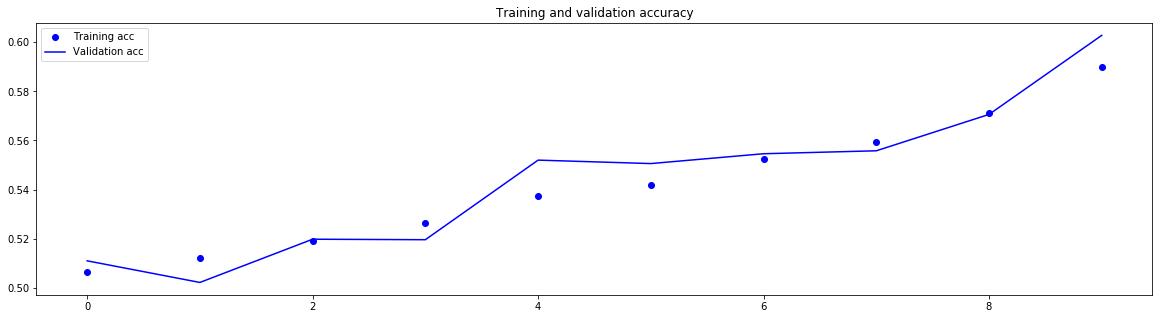

In [10]:
def plot_history(history, samples=10, init_phase_samples=None):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]

    fig, ax = plt.subplots(figsize=(20,5))

    ax.plot(acc, 'bo', label='Training acc')
    ax.plot(val_acc, 'b', label='Validation acc')
    ax.set_title('Training and validation accuracy')
    ax.legend()

plot_history(history)

In [12]:
# precition
model.predict(input_test[0:5])

array([[0.486188  ],
       [0.49295387],
       [0.47836104],
       [0.49150866],
       [0.6266455 ]], dtype=float32)

In [13]:
# ground truth
y_test[0:5]

array([0, 1, 1, 0, 1], dtype=int64)